# Setup

In [12]:
%%capture
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import os
import numpy as np
import pandas as pd
import scipy

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)

In [4]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

## Set data paths

### demeter

In [5]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [6]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Import data

In [7]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")

## UMAP gene list helper method

In [8]:
def plot_gene_list(adata, gene_list, layer, obs_key=None, obs_list=None, *arg, **kwarg):
    vmin = []
    vmax = []
    for gene in gene_list:
        if obs_key is None:
            if scipy.sparse.issparse(adata.layers[layer]):
                data = np.asarray(adata[:, gene].layers[layer].todense())
            else:
                data = adata[:, gene].layers[layer]
        else:
            if scipy.sparse.issparse(adata.layers[layer]):
                data = np.asarray(adata[adata.obs[obs_key] == obs_list[0], gene].layers[layer].todense())
            else:
                data = adata[adata.obs[obs_key] == obs_list[0], gene].layers[layer]
        vmin.append(np.quantile(data, 0.01))
        vmax.append(np.quantile(data, 0.99))
    if obs_key is None:
        sc.pl.umap(
            adata,
            color=gene_list,
            layer=layer,
            vmin=vmin,
            vmax=vmax,
            *arg, **kwarg
        )
    else:
        for obs in obs_list:
            sc.pl.umap(
                adata[adata.obs[obs_key] == obs],
                color=gene_list,
                layer=layer,
                vmin=vmin,
                vmax=vmax,
                *arg, **kwarg
            )

# Plots

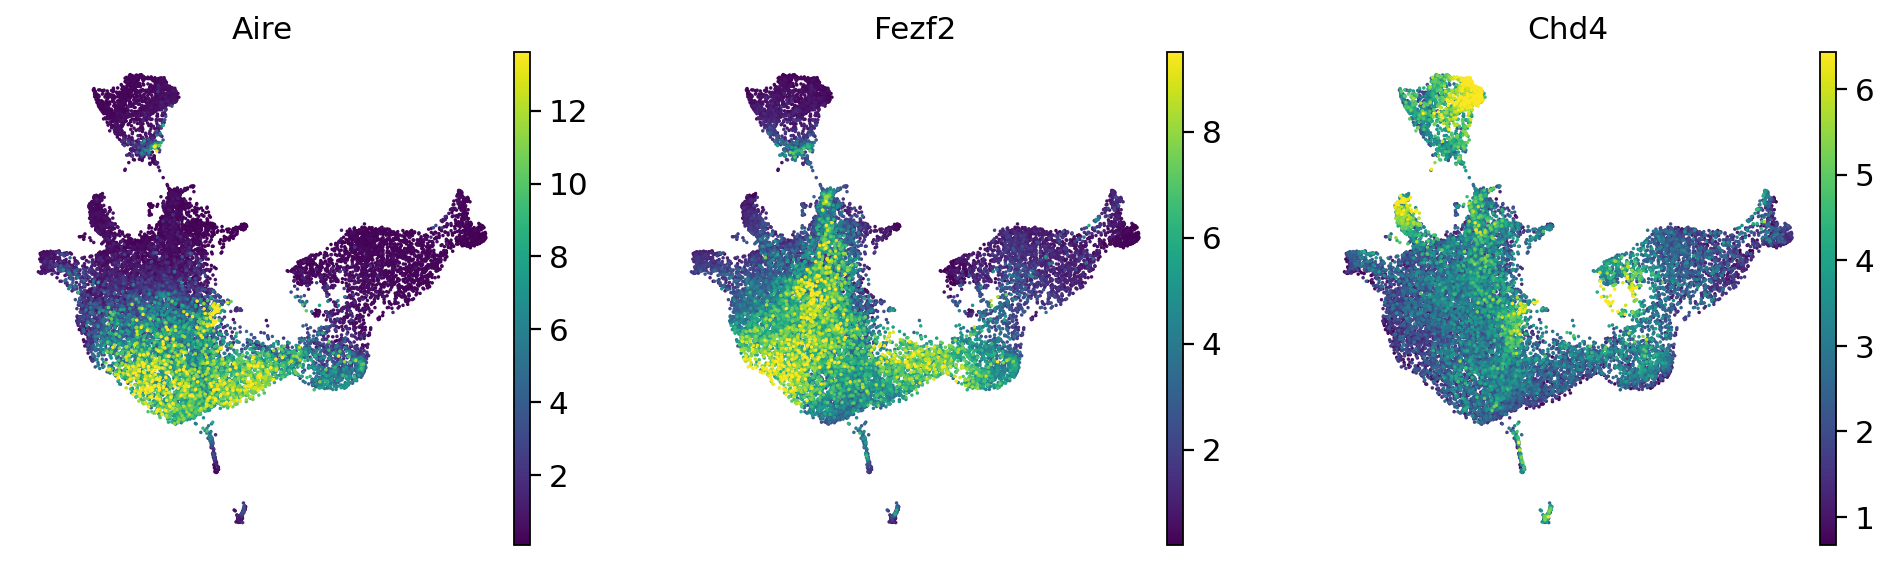

In [13]:
plot_gene_list(
    adata[adata.obs.genotype=="WT"],
    gene_list=["Aire", "Fezf2", "Chd4"],
    layer="scVI_normalized",
    s=10
)

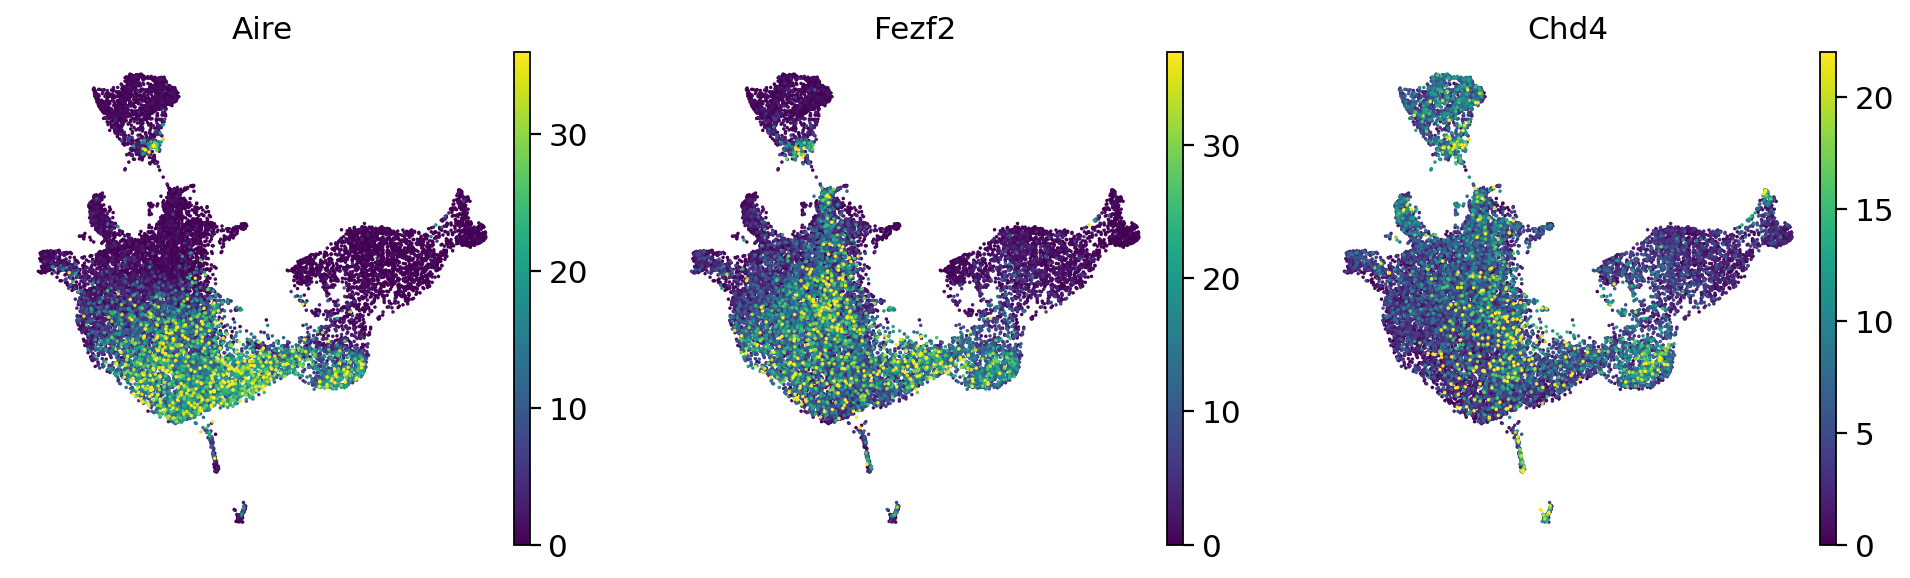

In [14]:
plot_gene_list(
    adata[adata.obs.genotype=="WT"],
    gene_list=["Aire", "Fezf2", "Chd4"],
    layer="counts",
    s=10
)